In [2]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

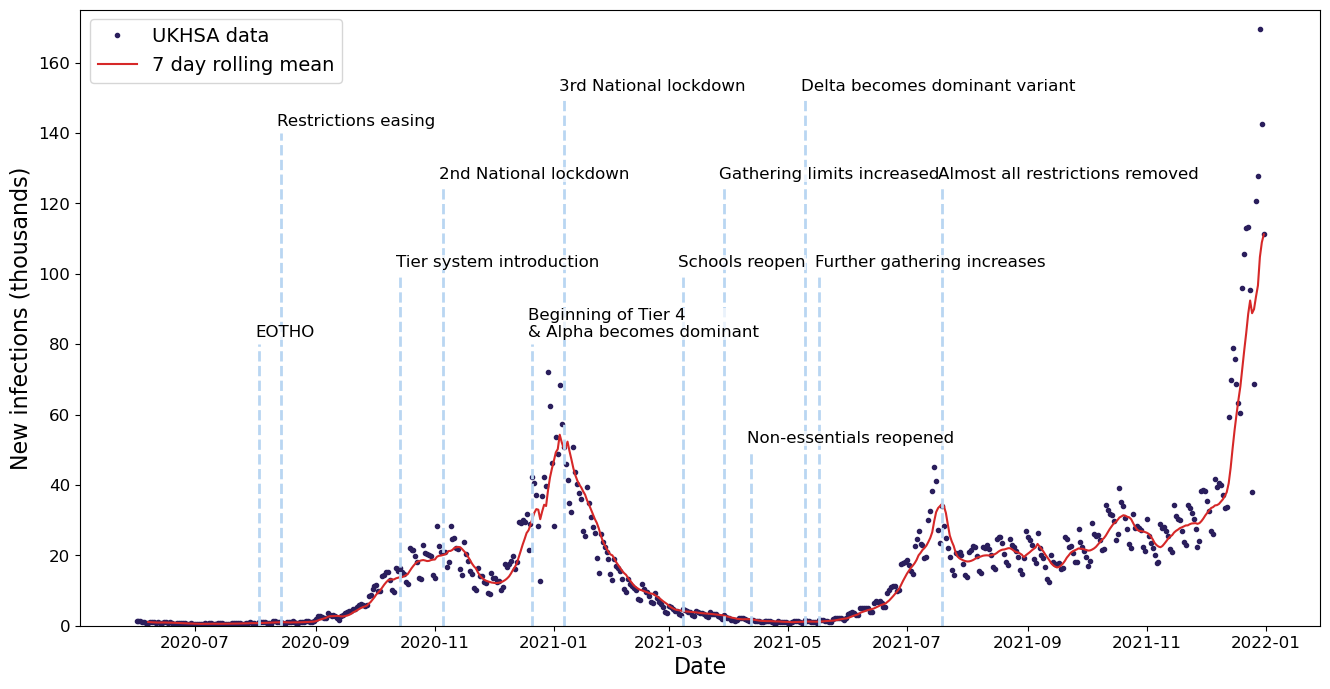

In [11]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14.csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns='areaType',inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20 = pd.concat([cases20,cases20_additional])
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases['value'] = cases['value'] / 1000
cases_total = cases.groupby('date').sum().reset_index()[['date','value']]
cases_total['rolling'] = cases_total['value'].rolling(7).mean()
cases_total.set_index('date')

# Incidence plot with key timeline events/expected bifurcations
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(cases_total['date'],cases_total['value'],".",label="UKHSA data",color='#2A1E5C')
ax.plot(cases_total['date'],cases_total['rolling'],label="7 day rolling mean",color='#D62828')

locs = ['2020-08-03','2020-08-14','2020-10-14','2020-11-05','2020-12-21','2021-01-06','2021-03-08','2021-03-29','2021-04-12','2021-05-10','2021-05-17','2021-07-19']
locs = np.array(locs, dtype='datetime64')
labs = ['EOTHO','Restrictions easing','Tier system introduction','2nd National lockdown','Beginning of Tier 4\n& Alpha becomes dominant',
        '3rd National lockdown','Schools reopen','Gathering limits increased','Non-essentials reopened','Delta becomes dominant variant','Further gathering increases','Almost all restrictions removed']
heights = np.array([80000,140000,100000,125000,80000,150000,100000,125000,50000,150000,100000,125000]) / 1000
ax.vlines(locs,ymin = 0, ymax = heights, linestyle='--',color='#B9D6F2',lw=2)
for date, lab, ht in zip(locs, labs, heights):
    ax.annotate(lab, xy=(date, ht),
                xytext=(-3, np.sign(ht)*3), textcoords="offset points",
                fontsize=12,
                verticalalignment="bottom",
                weight="normal",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('New infections (thousands)',fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim((0,175))
plt.legend(fontsize=14,loc='upper left')
plt.savefig('Figures/covidtimeline.pdf',dpi=2400,bbox_inches='tight')
plt.show()

In [12]:
with open('Data/hodcroftlab_covariants_master_web_public_data_perCountryData.json') as f:
    variants = json.load(f)

In [13]:
var_test = {}
for i in range(len(variants['regions'][0]['distributions'][1]['distribution'])):
    current = variants['regions'][0]['distributions'][1]['distribution'][i]
    alpha = current['cluster_counts']['20I (Alpha, V1)']
    delta = current['cluster_counts']['21A (Delta)'] + current['cluster_counts']['21I (Delta)'] + current['cluster_counts']['21J (Delta)']
    total = current['total_sequences']
    other = total - alpha - delta
    var_test[i] = [current['week'], alpha/total, delta/total, other/total]

In [14]:
colors = ['#2A1E5C','#D62828','#B9D6F2'] #35524A
labels = ["Alpha variant", "Delta variant", "Other variants"]

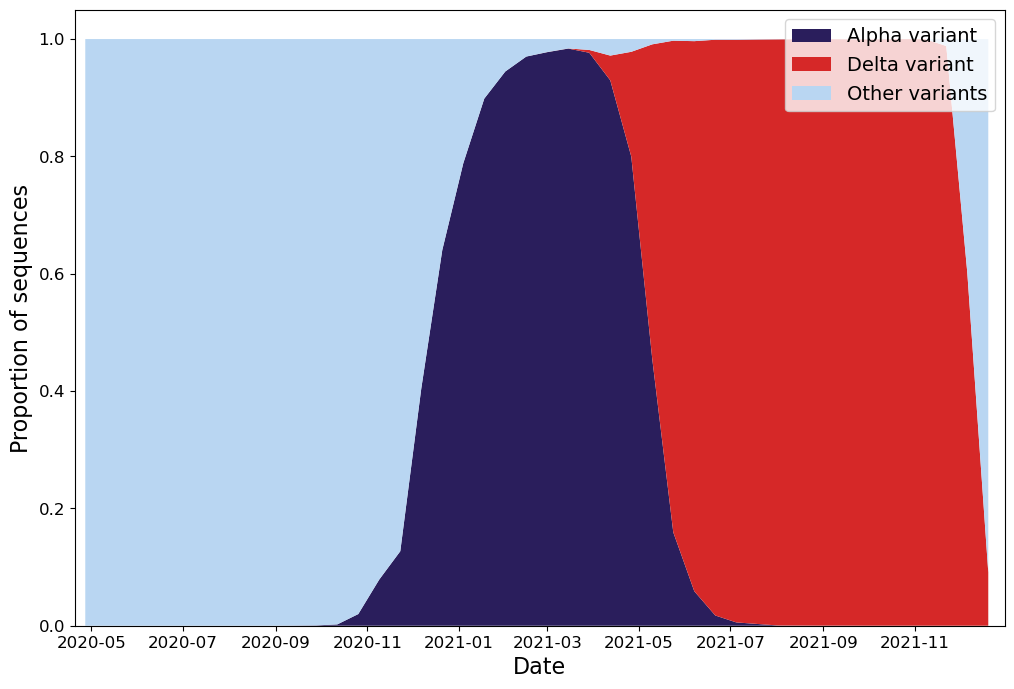

In [17]:
test = pd.DataFrame.from_dict(var_test).T
test.columns = ['date','alpha','delta','other']
test = test[test['date'] < '2022-01-01']
test['date'] = pd.to_datetime(test['date'])
test['alpha'] = pd.to_numeric(test['alpha'])
test['delta'] = pd.to_numeric(test['delta'])
test['delta'] = pd.to_numeric(test['delta'])
test['other'] = pd.to_numeric(test['other'])
xs = test['date'].values
ys = [test['alpha'].values,test['delta'].values,test['other'].values]
fig, ax = plt.subplots(figsize=(12,8))
ax.stackplot(xs, ys, colors=colors, labels=labels)
ax.set_xlim([np.datetime64('2020-04-20'),np.datetime64('2021-12-31')])
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Proportion of sequences',fontsize=16)
ax.tick_params('x',labelsize=12)
ax.tick_params('y',labelsize=12)
plt.legend(fontsize=14)
plt.savefig('Figures/variantstimeline.pdf',dpi=2400,bbox_inches='tight')
plt.show()